## Objective
In this exercise, your goal is to correctly identify digits from a dataset of handwritten images.

The dataset contains gray-scale images of hand-drawn digits, from zero through nine. It contains 42,000 images.
Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.
The data set, has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.
Each pixel column in the training set has a name like pixelx, where x is an integer between 0 and 783, inclusive. To locate this pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27, inclusive. Then pixelx is located on row i and column j of a 28 x 28 matrix, (indexing by zero).

You are expected to:
- Experiment with different models and settings and decide on the best model for this dataset
- Write a brief report (2-4 pages maximum) describing the choices you made and the evaluation you performed

### Import Libraries


In [27]:
# Basic packages
import pandas as pd
import numpy as np
import random
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# Machine learning packages
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
from sklearn.svm import SVC

# Utilities
import os 
import gc

### Load the Dataset

In [2]:
all_digits     = pd.read_csv('digit_recognizer_dataset.csv')

### Data Overview

In [ ]:
all_digits.head()

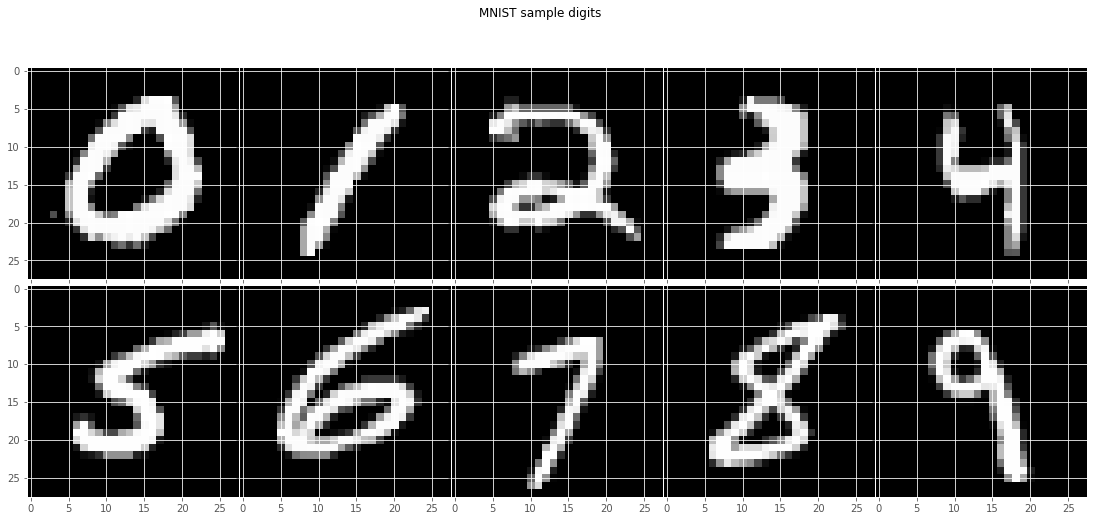

In [3]:
def print_digit():
    fig, axs = plt.subplots(2,5,sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0, 'wspace': 0},figsize=(19,8))
    fig.suptitle('MNIST sample digits')
    for i in range(0,10):
        digit = all_digits.loc[all_digits['label'] == i]
        digit = digit.iloc[random.randint(0, len(digit.index))][1:]
        digit = np.array(digit, dtype='float')
        pixels = digit.reshape((28, 28))
        axs[int(i/5), i % 5].imshow(pixels, cmap='gray')


print_digit()

Text(0, 0.5, 'Frequency')

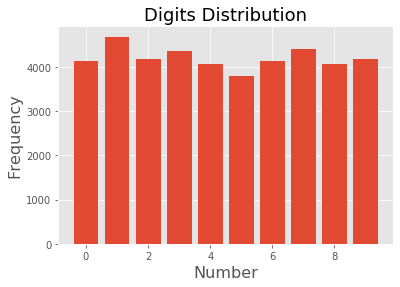

In [49]:
x = []
y = []
for i in range(0,10):
    digit = all_digits.loc[all_digits['label'] == i]
    x.append(i)
    y.append(len(digit.index))

plt.bar(x, y)
plt.title('Digits Distribution', fontsize=18)
plt.xlabel('Number', fontsize=16)
plt.ylabel('Frequency', fontsize=16)


### Train / Test Split

In [50]:
features = all_digits.columns[1:]
X = all_digits[features]
y = all_digits['label']
X_train, X_test, y_train, y_test = train_test_split(X/255.,y,test_size=0.1,random_state=0)

### Models Declaration


In [51]:

# Create a list, with one item per algorithm. Each item has a name, and a classifier object.
models = []
models.append(('XGB',  XGBClassifier()))
models.append(('LR' ,  LogisticRegression()))
models.append(('LDA',  LinearDiscriminantAnalysis()))
models.append(('kNN',  KNeighborsClassifier()))
models.append(('DT' ,  DecisionTreeClassifier()))
models.append(('MLP',  MLPClassifier()))
models.append(('RF' ,  RandomForestClassifier()))
models.append(('SVM',  SVC()))

### Models Comparison

In [52]:
results = []
names   = []
for name, model in models:
  cv_results = cross_val_score(model, X_train, y_train, scoring='accuracy', n_jobs= -1, verbose=2)
  results.append(cv_results)
  names.append(name)
  print("%03s: %f (+/- %f)" % (name, cv_results.mean(), cv_results.std()))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  7.3min remaining: 11.0min
XGB: 0.931402 (+/- 0.003344)
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  9.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  9.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   10.8s remaining:   16.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
 LR: 0.917487 (+/- 0.002200)
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   15.1s remaining:   22.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.0s finished
[Parallel(n_job

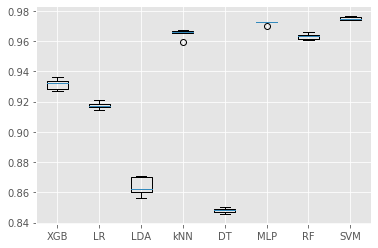

In [53]:
plt.boxplot(results)
plt.xticks(list(range(1,len(names)+1)), names)
plt.show()

### HyperParameter Tunning

In [54]:
from time import time
from scipy.stats import randint as sp_randint

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# build a classifier
clf = RandomForestClassifier(n_estimators=100)


# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


In [10]:
# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search)

start = time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 249.41 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.960 (std: 0.002)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 6, 'min_samples_leaf': 1, 'min_samples_split': 9}

Model with rank: 2
Mean validation score: 0.956 (std: 0.003)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 9, 'min_samples_leaf': 5, 'min_samples_split': 10}

Model with rank: 3
Mean validation score: 0.953 (std: 0.003)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': 8, 'min_samples_leaf': 4, 'min_samples_split': 5}



In [55]:
# use a full grid over all parameters
param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid)
start = time()
grid_search.fit(X_train, y_train)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)

GridSearchCV took 3072.51 seconds for 216 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.965 (std: 0.002)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 10, 'min_samples_leaf': 1, 'min_samples_split': 3}

Model with rank: 2
Mean validation score: 0.965 (std: 0.002)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}

Model with rank: 3
Mean validation score: 0.965 (std: 0.002)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 10, 'min_samples_leaf': 1, 'min_samples_split': 3}



### HyperParameter Tunning Version 2

In [56]:
max_depth      = [5   , 6   , 7   ]
subsample      = [0.7 , 0.8 , 0.9 ]
reg_alpha      = [0   , 0.1 , 0.2 ]
reg_lamda      = [1   , 1.1 , 1.2 ]


iterables = [ max_depth, subsample, reg_alpha, reg_lamda]

combinations = []
for t in itertools.product(*iterables):
    combinations.append(t)


In [63]:
params_accuracy = []
eval_set = [(X_train,y_train), (X_test, y_test)]
for params in combinations:
    model = XGBClassifier(n_estimators=200,n_jobs=-1,verbose=0,max_depth=params[0],subsample=params[1],
                                reg_alpha=params[2],reg_lambda=params[3])
    model.fit(X_train, y_train, early_stopping_rounds=10, eval_metric=["merror"], eval_set=eval_set)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    params_accuracy.append(accuracy)

best_params = combinations[np.argmax(params_accuracy)]


	validation_0-merror:0.000556	validation_1-merror:0.034762
[95]	validation_0-merror:0.00045	validation_1-merror:0.034762
[96]	validation_0-merror:0.000423	validation_1-merror:0.034524
[97]	validation_0-merror:0.000344	validation_1-merror:0.034762
[98]	validation_0-merror:0.000291	validation_1-merror:0.034048
[99]	validation_0-merror:0.000291	validation_1-merror:0.034286
[100]	validation_0-merror:0.000291	validation_1-merror:0.034286
[101]	validation_0-merror:0.000238	validation_1-merror:0.034048
[102]	validation_0-merror:0.000212	validation_1-merror:0.034048
[103]	validation_0-merror:0.000185	validation_1-merror:0.03381
[104]	validation_0-merror:0.000159	validation_1-merror:0.033571
[105]	validation_0-merror:0.000159	validation_1-merror:0.033571
[106]	validation_0-merror:0.000159	validation_1-merror:0.033333
[107]	validation_0-merror:0.000132	validation_1-merror:0.032857
[108]	validation_0-merror:0.000132	validation_1-merror:0.032619
[109]	validation_0-merror:0.000132	validation_1-merr

In [66]:
print("max accuracy = " + str(np.max(params_accuracy)))
print("best parameters: \n" + "max_depth:"+str(best_params[0])+"\n"
        + "subsample:"+str(best_params[1])+"\n"
        + "reg_alpha:"+str(best_params[2])+"\n"
        + "reg_lamda:"+str(best_params[3])+"\n" )

max accuracy = 0.9726190476190476
best parameters: 
max_depth:6
subsample:0.9
reg_alpha:0
reg_lamda:1.1



### Model Train

In [64]:
# fit model no training data
model = XGBClassifier(n_estimators=200,n_jobs=-1,verbose=0,max_depth=best_params[0],subsample=best_params[1],
                                reg_alpha=best_params[2],reg_lambda=best_params[3])
eval_set = [(X_train,y_train), (X_test, y_test)]
model.fit(X_train, y_train, early_stopping_rounds=10, eval_metric=["merror"], eval_set=eval_set)
y_pred = model.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)





[0]	validation_0-merror:0.126905	validation_1-merror:0.159286
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 10 rounds.
[1]	validation_0-merror:0.102619	validation_1-merror:0.12381
[2]	validation_0-merror:0.088228	validation_1-merror:0.108095
[3]	validation_0-merror:0.079471	validation_1-merror:0.102619
[4]	validation_0-merror:0.074153	validation_1-merror:0.098095
[5]	validation_0-merror:0.070106	validation_1-merror:0.094286
[6]	validation_0-merror:0.06672	validation_1-merror:0.088333
[7]	validation_0-merror:0.063889	validation_1-merror:0.086667
[8]	validation_0-merror:0.06082	validation_1-merror:0.08381
[9]	validation_0-merror:0.058333	validation_1-merror:0.082381
[10]	validation_0-merror:0.056587	validation_1-merror:0.080476
[11]	validation_0-merror:0.054074	validation_1-merror:0.079048
[12]	validation_0-merror:0.052619	validation_1-merror:0.077143
[13]	validation_0-merror:0.05097

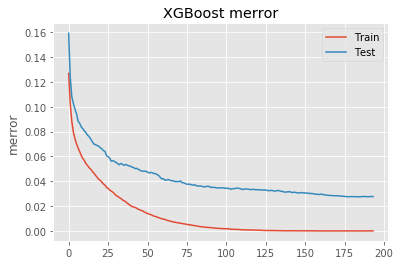

In [67]:
# plot Train/Test error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('merror')
plt.title('XGBoost merror')
plt.show()